In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


In [2]:
#Load the dataset, take a look at the data info: 
df_1 = pd.read_csv('Data/DF_1_clean.csv')
df_1.set_index('Date', inplace=True)
df_2 = pd.read_csv('Data/DF_2_clean.csv')
df_2.set_index('Date', inplace=True)
df_3 = pd.read_csv('Data/DF_3_clean.csv')
df_3.set_index('Date', inplace=True)

# Resort 1

### First Simple Model
Linear Regression with Cross Validation: 

In [ ]:
#Split into test and train X and Y
X = df_1.drop(columns=['TOTAL_VISITS'])
y = df_1['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
y.head()

In [ ]:
#visualization of target - Visits
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(y, bins=100);


In [ ]:
#Split into test and train X and Y
# X = df_1.drop(columns=['TOTAL_VISITS'])
# y = df_1['TOTAL_VISITS']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

cat = ['is_school_out', 'is_holiday', 'day_of_week_num', 'month']
non_cat = ['T - AWND', 'T - PRCP', 'T - SNOW', 'T - SNWD', 'T - TAVG', 'M_PRCP', 'M_SNWD', 'M_TAVG']


Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	('scaler', StandardScaler(), non_cat),
	], remainder ='passthrough')

#setting up the pipe and training the model: 

LRPipe = Pipeline([('trans', Transformer),
                ('linreg', LinearRegression())])

LRPipe.fit(X_train, y_train)

#cross validation and scoring
cv = cross_validate(LRPipe, X_train, y_train, return_train_score=True, cv=3)
cv_score = cross_val_score(LRPipe, X_train, y_train, cv = 3)

print(f'Cross Validation Scores: {cv}')

print(f'mean CV Score: {cv_score.mean()}')

With Encoding and scaling, the Basic Linear Regression CV score is 0.576

There is definitly some room for improvement! 

## Tree Regressor

In [ ]:
#Split into test and train X and Y
X = df_1.drop(columns=['TOTAL_VISITS'])
y = df_1['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#column transformer - this sets up simmilar to pipeline (scaler and transformer)
# cat = ['is_school_out', 'is_holiday', 'day_of_week_num', 'month']
# non_cat = ['T - AWND', 'T - PRCP', 'T - SNOW', 'T - SNWD', 'T - TAVG', 'M_PRCP', 'M_SNWD', 'M_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

dtr = DecisionTreeRegressor(random_state=42)

TreeRegPipe = Pipeline([('trans', Transformer),
                        ('dtr', dtr)])

dtr_param_grid = {
	'dtr__splitter': ['best', 'random'],
    'dtr__min_samples_split': [4, 6, 8, 10],
    'dtr__max_depth': [4, 5, 6, 7, 8]
}		

#set up gridsearch:
TreeGrid = GridSearchCV(estimator=TreeRegPipe,
						  param_grid=dtr_param_grid,
						  cv=3)

TreeGrid.fit(X_train, y_train)

#cross validation and scoring
cv = cross_validate(TreeGrid, X_train, y_train, return_train_score=True, cv=3)
cv_score = cross_val_score(TreeGrid, X_train, y_train, cv = 3)

print("Best Parameter Combination for Tree Regressor Found During Grid Search:")
print(TreeGrid.best_params_)

print(f'Tree Grid Cross Validation Scores: {cv}')

print(f'Tree Grid mean CV Score: {cv_score.mean()}')

Tree Regressor did not perform well with the best score of .278 in comparison to linear regression with a score of .576

## Random Forests 

In [ ]:
#pipeline_3:
from sklearn.ensemble import RandomForestRegressor

# #Split into test and train X and Y
# X = df_3_preprocessed.drop(columns=['TOTAL_VISITS'])
# y = df_3_preprocessed['TOTAL_VISITS']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

# cat = ['is_school_out', 'is_holiday', 'day_of_week_num', 'month]
# non_cat = ['T - AWND', 'T - PRCP', 'T - SNOW', 'T - SNWD', 'T - TAVG', 'M_PRCP', 'M_SNWD', 'M_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
rfr = RandomForestRegressor(random_state = 42)

#pipeline
pipeline_3 = Pipeline([('transformer', Transformer),
						('dtr', rfr)])

#set up grid search paramater grid
rfr_param_grid = {
    'dtr__n_estimators': [2, 4, 6, 8, 10, 12, 14, 16],
    'dtr__max_depth': [None, 2, 3, 4, 5, 6, 8, 10],
	'dtr__max_features': ['auto', 'sqrt', 'log2'],
	'dtr__criterion': ['mse', 'mae']
}

#set up gridsearch:
gridsearch2 = GridSearchCV(estimator=pipeline_3,
						  param_grid=rfr_param_grid,
						  cv=3)

#fit gridsearch
gridsearch2.fit(X_train, y_train)


print("Best Parameter Combination Found During Grid Search:")
print(gridsearch2.best_params_)

In [ ]:
#pipeline_3:

#Split into test and train X and Y
X = df_1.drop(columns=['TOTAL_VISITS'])
y = df_1['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

# cat = ['is_school_out', 'is_holiday', 'day_of_week_num', 'month']
# non_cat = ['T - AWND', 'T - PRCP', 'T - SNOW', 'T - SNWD', 'T - TAVG', 'M_PRCP', 'M_SNWD', 'M_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
rfr = RandomForestRegressor(criterion = 'mse', max_depth = None, max_features = 'sqrt', n_estimators = 10, random_state = 42)

#pipeline
pipeline_3 = Pipeline([('transformer', Transformer),
						('dtr', rfr)])


pipeline_3.fit(X_train, y_train)

cv = cross_validate(pipeline_3, X_train, y_train, return_train_score=True, cv=5)
cv_score = cross_val_score(pipeline_3, X_train, y_train, cv = 5)
print(f'Cross Validation Scores best Random Forest Regressor: {cv}')

print(f'mean CV Score: {cv_score.mean()}')

For Resort 1, forests are performing better than trees with a CV score of .638!

## Gradient Boosting: 

In [ ]:


#pipeline_4:

#Split into test and train X and Y
# X = df_1.drop(columns=['TOTAL_VISITS'])
# y = df_1['TOTAL_VISITS']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

# cat = ['is_school_out', 'is_holiday', 'day_of_week_num']
# non_cat = ['T - AWND', 'T - PRCP', 'T - SNOW', 'T - SNWD', 'T - TAVG', 'M_PRCP', 'M_SNWD', 'M_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
GBR = GradientBoostingRegressor(random_state = 42)

#pipeline
pipeline_4 = Pipeline([('transformer', Transformer),
						('gbr', GBR)])

#set up grid search paramater grid
gbr_param_grid = {
    'gbr__n_estimators': [50, 100, 200, 300],
    'gbr__criterion': ['friedman_mse', 'mse', 'mae'],
	'gbr__min_samples_split': [2, 3, 4, 5]
}

#set up gridsearch:
gridsearch3 = GridSearchCV(estimator=pipeline_4,
						  param_grid=gbr_param_grid,
						  cv=5)


#fit gridsearch
gridsearch3.fit(X_train, y_train)

print("Best Parameter Combination Found During Gradient Boosting Grid Search:")
print(gridsearch3.best_params_)


In [ ]:
#Using best params on a gradient booster regressor then scoring thorugh cross val: 

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

# cat = ['is_school_out', 'is_holiday', 'day_of_week_num', 'month']
# non_cat = ['T - AWND', 'T - PRCP', 'T - SNOW', 'T - SNWD', 'T - TAVG', 'M_PRCP', 'M_SNWD', 'M_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
# GBR = GradientBoostingRegressor(criterion='mse', n_estimators=200, random_state = 42)
GBR = GradientBoostingRegressor(criterion='mse', n_estimators=200, min_samples_split= 5, random_state = 42)

#pipeline
pipeline_gbr = Pipeline([('transformer', Transformer),
						('gbr', GBR)])

pipeline_gbr.fit(X_train, y_train)


cv = cross_validate(pipeline_gbr, X_train, y_train, return_train_score=True, cv=5)
cv_score = cross_val_score(pipeline_gbr, X_train, y_train, cv = 5)
print(f'Cross Validation Score Gradient Boosting Model: {cv}')

print(f'mean CV Score: {cv_score.mean()}')

### Gradient Booster Regressor is doing the best: 

And more improvement! We got our average model CV score up to .691

In [ ]:
import xgboost as xg

from sklearn.ensemble import GradientBoostingRegressor

#x_boost Pipe:

# X = df_1.drop(columns=['TOTAL_VISITS'])
# y = df_1['TOTAL_VISITS']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline first step: Transformer

# cat = ['is_school_out', 'is_holiday', 'day_of_week_num', 'month']
# non_cat = ['T - AWND', 'T - PRCP', 'T - SNOW', 'T - SNWD', 'T - TAVG', 'M_PRCP', 'M_SNWD', 'M_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	('scaler', StandardScaler(), non_cat),
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
xgb_r = xg.XGBRegressor(seed = 123)

#pipeline
xboostPipe = Pipeline([('transformer', Transformer),
						('xgb_r', xgb_r)])

# objective ='reg:squarederror', n_estimators = 10, 
boost_param_grid = {
    'xgb_r__eta': [.2, .3, .4, .5, .6, .7, .8],
	'xgb_r__max_depth': [3, 4, 5, 6, 7, 8, 9, 10]
}

gridsearch_boost = GridSearchCV(estimator=xboostPipe,
						  param_grid=boost_param_grid,
						  cv=5)

#fit gridsearch
gridsearch_boost.fit(X_train, y_train)

print("Best Parameter Combination Found During Grid Search:")
print(gridsearch_boost.best_params_)

In [ ]:
#x_boost Pipe with ideal paramaters:

# X = df_1.drop(columns=['TOTAL_VISITS'])
# y = df_1['TOTAL_VISITS']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline first step: Transformer
# cat = ['is_school_out', 'is_holiday', 'day_of_week_num', 'month']
# non_cat = ['T - AWND', 'T - PRCP', 'T - SNOW', 'T - SNWD', 'T - TAVG', 'M_PRCP', 'M_SNWD', 'M_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	('scaler', StandardScaler(), non_cat),
	], remainder ='passthrough')

#Pipeline second Step: 
xgb_r_2 = xg.XGBRegressor(eta = 0.2, max_depth = 3, seed = 123)

xboostPipe_2 = Pipeline([('transformer', Transformer),
						('xgb_r_2', xgb_r_2)])

xboostPipe_2.fit(X_train, y_train)

cv = cross_validate(xboostPipe_2, X_train, y_train, return_train_score=True, cv=5)
cv_score = cross_val_score(xboostPipe_2, X_train, y_train, cv = 5)
print(f'Cross Validation Scores: {cv}')

print(f'mean CV Score: {cv_score.mean()}')

X boost for resort 1 is preforming slightly better than Gradient Booster Regressor at CV score of .701

## Evaluation

**XBoost** 

In [ ]:
#GBR Test Score
xboostPipe_2.score(X_test, y_test)

XBoost gets a test CV score of .782, this means we can account for 78% of the variance in the Resort 1 data with our Gradient Booster Regressor model. 

In [ ]:
y_pred_xboost = xboostPipe_2.predict(X_test)

df = pd.DataFrame({'Real Visits Resort 1':y_test, 'Predicted XBoost Visits':y_pred_xboost, 
                    'Difference': abs(y_test - y_pred_xboost)})
df.head()


In [ ]:
df['Difference'].mean()

In [ ]:
ohe = xboostPipe_2.named_steps["transformer"].transformers_[0][1].get_feature_names()
numbers = non_cat

columns = [*ohe, *numbers]

for name, importance in zip(columns, xboostPipe_2['xgb_r_2'].feature_importances_):
    print(name, importance)


In [ ]:
from sklearn.inspection import permutation_importance

feature_importance = xboostPipe_2['xgb_r_2'].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])
fig = plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(columns)[sorted_idx])
plt.title("Feature Importance")

result = permutation_importance(
    xboostPipe_2, X_test, y_test, n_repeats=19, random_state=42, n_jobs=2
)
result
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Resort 2 Modeling

## Resort 2 Base Model

Start with basic Linear Regression with OHE and standard scaler for our Resort 2 Base Model

In [8]:
#Split into test and train X and Y - labled 2 for resort 2
X2 = df_2.drop(columns=['TOTAL_VISITS'])
y2 = df_2['TOTAL_VISITS']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [9]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 468 entries, 2015-12-14 to 2021-04-18
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   IS_SCHOOL_OUT    468 non-null    int64  
 1   IS_HOLIDAY       468 non-null    int64  
 2   TOTAL_VISITS     468 non-null    int64  
 3   M_TEMPAVERAGE_F  468 non-null    int64  
 4   M_PRECIP_INCHES  468 non-null    float64
 5   T_PRCP           468 non-null    float64
 6   T_TAVG           468 non-null    float64
 7   day_of_week_num  468 non-null    int64  
 8   Month            468 non-null    int64  
dtypes: float64(3), int64(6)
memory usage: 56.6+ KB


In [ ]:
#visualization of target - Visits
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(y2, bins=100);

In [11]:
# #Split into test and train X and Y - labled 2 for resort 2
# X2 = df_2.drop(columns=['TOTAL_VISITS'])
# y2 = df_2['TOTAL_VISITS']
# X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

cat = ['IS_HOLIDAY', 'day_of_week_num', 'Month', 'IS_SCHOOL_OUT']
non_cat = ['M_TEMPAVERAGE_F', 'M_PRECIP_INCHES', 'T_PRCP', 'T_TAVG',]


Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	('scaler', StandardScaler(), non_cat),
	], remainder ='passthrough')

#setting up the pipe and training the model: 

LR_resort2 = LinearRegression()

LRPipe_resort2 = Pipeline([('trans', Transformer),
                ('linreg_resort2', LR_resort2)])

LRPipe_resort2.fit(X_train2, y_train2)

#cross validation and scoring
lr_cv_resort2 = cross_validate(LRPipe_resort2, X_train2, y_train2, return_train_score=True, cv=5)
lr_cv_score_resort2 = cross_val_score(LRPipe_resort2, X_train2, y_train2, cv = 5)

print(f'Cross Validation Scores, Linear Regression, Resort 2: {lr_cv_resort2}')

print(f'mean CV Score, Linear Regression, Resort 2: {lr_cv_score_resort2.mean()}')

Cross Validation Scores, Linear Regression, Resort 2: {'fit_time': array([0.01873899, 0.02753568, 0.03098607, 0.01676989, 0.01431894]), 'score_time': array([0.00949883, 0.01742005, 0.01185203, 0.01299691, 0.01266909]), 'test_score': array([0.28257942, 0.4323264 , 0.29244525, 0.4724927 , 0.38015785]), 'train_score': array([0.46812703, 0.43163345, 0.46853585, 0.41525936, 0.43788248])}
mean CV Score, Linear Regression, Resort 2: 0.37200032562717567


For Resort 2, Basic Linear Regression CV score is .372

Because Tree Regressors didn't perform well with Resort 1, we are skipping it and moving straight to Random Forest Models

## Random Forest, Resort 2

In [14]:
# #Split into test and train X and Y - labled 2 for resort 2
# X2 = df_2.drop(columns=['TOTAL_VISITS'])
# y2 = df_2['TOTAL_VISITS']
# X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

# # column transformer - this sets up simmilar to pipeline (scaler and transformer)

# cat = ['IS_HOLIDAY', 'day_of_week_num', 'Month', 'IS_SCHOOL_OUT']
# non_cat = ['M_TEMPAVERAGE_F', 'M_PRECIP_INCHES', 'T_PRCP', 'T_TAVG',]

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
rfr_resort2 = RandomForestRegressor(random_state = 42)

#pipeline
rfr_pipeline_resort2 = Pipeline([('transformer', Transformer),
						('rfr', rfr_resort2)])

#set up grid search paramater grid
rfr_param_grid = {
    'rfr__n_estimators': [10, 12, 14, 16, 18, 20, 22],
    'rfr__max_depth': [None, 2, 3, 4, 5, 6, 8],
	'rfr__max_features': ['auto', 'sqrt', 'log2'],
	'rfr__criterion': ['mse', 'mae']
}

#set up gridsearch:
gridsearch_RFR_resort2 = GridSearchCV(estimator=rfr_pipeline_resort2,
						  param_grid=rfr_param_grid,
						  cv=3)

#fit gridsearch
gridsearch_RFR_resort2.fit(X_train2, y_train2)


print("Best Parameter Combination Found During Grid Search:")
print(gridsearch_RFR_resort2.best_params_)

Best Parameter Combination Found During Grid Search:
{'rfr__criterion': 'mse', 'rfr__max_depth': None, 'rfr__max_features': 'sqrt', 'rfr__n_estimators': 20}


In [16]:
#pipeline_3:

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

# Pipeline second Step: treeregressor
rfr_resort2 = RandomForestRegressor(criterion = 'mse', max_depth = None, max_features = 'sqrt', n_estimators = 20, random_state = 42)

#pipeline
pipeline_RFR_resort2 = Pipeline([('transformer', Transformer),
						('dtr', rfr_resort2)])

pipeline_RFR_resort2.fit(X_train2, y_train2)

cv_RFR_resort2 = cross_validate(pipeline_RFR_resort2, X_train2, y_train2, return_train_score=True, cv=5)
cv_score_RFR_resort2 = cross_val_score(pipeline_RFR_resort2, X_train2, y_train2, cv = 5)
print(f'Cross Validation Scores best Random Forest Regressor, Resort 2: {cv_RFR_resort2}')

print(f'mean CV Score Random Forest Regressor, Resort 2: {cv_score_RFR_resort2.mean()}')

Cross Validation Scores best Random Forest Regressor, Resort 2: {'fit_time': array([0.118999  , 0.07402587, 0.05672407, 0.0606389 , 0.08700633]), 'score_time': array([0.01687503, 0.01024818, 0.00751996, 0.00781393, 0.01392174]), 'test_score': array([0.23347332, 0.17485327, 0.34279815, 0.52848325, 0.47884643]), 'train_score': array([0.9124275 , 0.91811556, 0.90745626, 0.90425414, 0.9032015 ])}
mean CV Score Random Forest Regressor, Resort 2: 0.35169088447881425


For Resort 2 we are getting dissapointing results with Random Forests at a CV score of .352

Linear Regression is still the best model at CV score of.372

## Gradient Boosting Resort 2: 

In [19]:
#pipeline_4:

# #Split into test and train X and Y - labled 2 for resort 2
# X2 = df_2.drop(columns=['TOTAL_VISITS'])
# y2 = df_2['TOTAL_VISITS']
# X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

# cat = ['IS_HOLIDAY', 'day_of_week_num', 'Month', 'IS_SCHOOL_OUT']
# non_cat = ['M_TEMPAVERAGE_F', 'M_PRECIP_INCHES', 'T_PRCP', 'T_TAVG',]

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
GBR_resort2 = GradientBoostingRegressor(random_state = 42)

#pipeline
pipeline_GBR_resort2 = Pipeline([('transformer', Transformer),
						('gbr', GBR_resort2)])

#set up grid search paramater grid
gbr_param_grid = {
    'gbr__n_estimators': [50, 100, 200, 300],
    'gbr__criterion': ['friedman_mse', 'mse', 'mae'],
	'gbr__min_samples_split': [2, 3, 4, 5]
}

#set up gridsearch:
gridsearch_GBR_resort2 = GridSearchCV(estimator=pipeline_GBR_resort2,
						  param_grid=gbr_param_grid,
						  cv=5)


#fit gridsearch
gridsearch_GBR_resort2.fit(X_train2, y_train2)

print("Best Parameter Combination Found During Gradient Boosting Grid Search:")
print(gridsearch_GBR_resort2.best_params_)

Best Parameter Combination Found During Gradient Boosting Grid Search:
{'gbr__criterion': 'mse', 'gbr__min_samples_split': 3, 'gbr__n_estimators': 100}


In [20]:
Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
# GBR = GradientBoostingRegressor(criterion='mse', n_estimators=200, random_state = 42)
GBR_resort2 = GradientBoostingRegressor(criterion='mse', n_estimators=100, min_samples_split= 3, random_state = 42)

#pipeline
pipeline_gbr_resort2 = Pipeline([('transformer', Transformer),
						('gbr_resort2', GBR_resort2)])

pipeline_gbr_resort2.fit(X_train2, y_train2)


cv_GBR_resort2 = cross_validate(pipeline_gbr_resort2, X_train2, y_train2, return_train_score=True, cv=2)
cv_score_GBR_resort2 = cross_val_score(pipeline_gbr_resort2, X_train2, y_train2, cv = 2)
print(f'Cross Validation Score Gradient Boosting Model, resort 2: {cv_GBR_resort2}')

print(f'mean CV Score Gradient Boosting Model, Resort 2: {cv_score_GBR_resort2.mean()}')

Cross Validation Score Gradient Boosting Model, resort 2: {'fit_time': array([0.07868218, 0.04807401]), 'score_time': array([0.00459385, 0.00411582]), 'test_score': array([0.21149079, 0.28310764]), 'train_score': array([0.87328365, 0.85150726])}
mean CV Score Gradient Boosting Model, Resort 2: 0.2472992146294175


Still can't beat Linear Regression. Resort two Gradient Boosting Model returned a cv of 0.247

# Resort 2 Discussion

maybe could combine Saturday and Sunday into weekend vs non-weekend? 

# Resort 3 Modeling

In [21]:
#Split into test and train X and Y
X3 = df_3.drop(columns=['TOTAL_VISITS'])
y3 = df_3['TOTAL_VISITS']
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=42)
X3.head()

,IS_HOLIDAY,SCHOOL_OUT,M_PRCP,M_SNWD,M_TAVG,T_AWND,T_PRCP,T_SNOW,T_TAVG,day_of_week_num,Month
Date,,,,,,,,,,,
2015-11-21,0,0,0.0,12,36,4.92,0.00,0.0,44,5,11
2015-11-27,0,1,0.0,11,35,6.26,0.00,0.0,36,4,11
2015-11-28,0,0,0.0,11,38,9.17,0.00,0.0,38,5,11
2015-11-29,0,0,0.0,11,39,12.30,0.00,0.0,36,6,11
2015-12-04,0,0,0.9,18,30,9.84,0.26,0.0,47,4,12


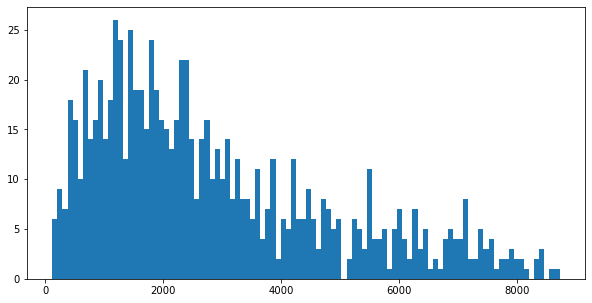

In [22]:
#take a peak at target for Resort 3: 
#visualization of target - Visits
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(y3, bins=100);

In [25]:
#Establish categorical vs non-categorical for Resort 3:

cat3 = ['IS_HOLIDAY', 'SCHOOL_OUT', 'day_of_week_num', 'Month']
non_cat3 = ['M_PRCP', 'M_SNWD', 'M_TAVG', 'T_AWND', 'T_PRCP', 'T_SNOW', 'T_TAVG']

# Resort 3 Baseline Model: Linear Regression

In [26]:
Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat3),
	('scaler', StandardScaler(), non_cat3),
	], remainder ='passthrough')

#setting up the pipe and training the model: 

LR_resort3 = LinearRegression()

LRPipe_resort3 = Pipeline([('trans', Transformer),
                ('linreg_3', LR_resort3)])

LRPipe_resort3.fit(X_train3, y_train3)

#cross validation and scoring
cv_resort3 = cross_validate(LRPipe_resort3, X_train3, y_train3, return_train_score=True, cv=5)
cv_score_resort3 = cross_val_score(LRPipe_resort3, X_train3, y_train3, cv = 5)

print(f'Cross Validation Scores, Linear Regression Resort 3: {cv_resort3}')

print(f'mean CV Score, Linear Regression, Resort 3: {cv_score_resort3.mean()}')

Cross Validation Scores, Linear Regression Resort 3: {'fit_time': array([0.04591608, 0.0387733 , 0.03699493, 0.02754593, 0.02274299]), 'score_time': array([0.02709317, 0.01405883, 0.01064396, 0.01336288, 0.01113319]), 'test_score': array([0.73442309, 0.68680334, 0.56572863, 0.6350925 , 0.60191432]), 'train_score': array([0.65846221, 0.67246198, 0.70186861, 0.68290785, 0.68913727])}
mean CV Score, Linear Regression, Resort 3: 0.6447923776236449


Resort 3 is off to a good start with a CV score of 0.645

## Decision Tree Regressor (DTR) - Resort 3

In [29]:
Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat3),
	# ('scaler', StandardScaler(), non_cat3), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
DTR_resort3 = DecisionTreeRegressor(random_state = 42)

#pipeline
DTR_pipeline_resort3 = Pipeline([('transformer', Transformer),
						('dtr', DTR_resort3)])

#set up grid search paramater grid
dt_param_grid = {
	'dtr__splitter': ['best', 'random'],
    'dtr__min_samples_split': [ 6, 8, 10, 12, 14, 16],
    'dtr__max_depth': [ 6, 7, 8, 9, 10, 11, 12, 13]
}

#set up gridsearch:
gridsearch_DTR_resort3 = GridSearchCV(estimator=DTR_pipeline_resort3,
						  param_grid=dt_param_grid,
						  cv=3)


#fit gridsearch
gridsearch_DTR_resort3.fit(X_train3, y_train3)


print("Best Parameter Combination Found During DRT Grid Search, Resort3:")
print(gridsearch_DTR_resort3.best_params_)

Best Parameter Combination Found During DRT Grid Search, Resort3:
{'dtr__max_depth': 9, 'dtr__min_samples_split': 14, 'dtr__splitter': 'random'}


In [33]:
#instantiate a DTR with best params, fit model and run cross validation scoring:

Transformer3 = ColumnTransformer([
	('ohe', OneHotEncoder(), cat3),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
DTR_resort3_best = DecisionTreeRegressor(max_depth=9, min_samples_split=14, splitter='random', random_state= 42)

#pipeline
pipeline_DTR_resort3_best = Pipeline([('transformer', Transformer3),
						('dtr_best_r3', DTR_resort3_best)])


pipeline_DTR_resort3_best.fit(X_train3, y_train3)

#cross validation and scoring
cv_DTR_resort3 = cross_validate(gridsearch_DTR_resort3, X_train3, y_train3, return_train_score=True, cv=3)
cv_score_DTR_resort3 = cross_val_score(gridsearch_DTR_resort3, X_train3, y_train3, cv = 3)

print(f'Cross Validation Scores, DTR, Resort 3: {cv_DTR_resort3}')

print(f'mean CV Score, DTR, Resort 3: {cv_score_DTR_resort3.mean()}')

Cross Validation Scores, DTR, Resort 3: {'fit_time': array([5.6295917 , 4.44097805, 4.45834208]), 'score_time': array([0.00439334, 0.00659609, 0.00633597]), 'test_score': array([0.61144268, 0.56875645, 0.40311561]), 'train_score': array([0.74147315, 0.80259764, 0.81874819])}
mean CV Score, DTR, Resort 3: 0.5277715790233293


For this dataset, forests are performing better than trees with a CV score of .68!